In [1]:
import os
import sys

import numpy as np 
import random
import time 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from IPython import display

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Start with vgg19
from tensorflow.keras.applications import vgg19

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Found GPU at: /device:GPU:0
Thu Jul 23 04:02:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    31W / 250W |    353MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                            

In [3]:
try: # detect TPUs
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # instantiate a distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

AUTO = tf.data.experimental.AUTOTUNE
print("Number of accelerators: ", strategy.num_replicas_in_sync)

MAINDIR = '/content/'
GIFDIR = '/content/GIFs/'
h5DIR = '/content/'
!mkdir GIFDIR


Number of accelerators:  1
mkdir: cannot create directory ‘GIFDIR’: File exists


In [4]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img_x(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    #resize
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
# this is the primary image to explore
content_path = '/content/Bacchus.jpg'

content = load_img_x(content_path)
tnew = vgg19.preprocess_input(content*255)
tnew = tf.image.resize(tnew, (224, 224))
# first test full VGG19
model = vgg19.VGG19(include_top=True, weights='imagenet')
probs = model(tnew)
probs.shape
top_5 = vgg19.decode_predictions(probs.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in top_5]

[('Airedale', 0.8730485),
 ('Lakeland_terrier', 0.06790492),
 ('Irish_terrier', 0.024518127),
 ('wire-haired_fox_terrier', 0.022631291),
 ('standard_poodle', 0.005026541)]

In [6]:
# well, he is a welshie, but we can forgive mistaking him for an airedale
model = vgg19.VGG19(include_top=False, weights='imagenet')

In [7]:
# loss functions
## content loss
def mat_loss(target, combo, scale = 1):
    # this is just pixel distance (squared)
    return K.sum(K.square(target-combo))/scale 

## gram matrix is dot product of features in the layer, this captures the style
## minimizing the gram matrix distances between the style and combo will be this loss
def gram_matrix(x):
    return tf.linalg.einsum('bijc,bijd->bcd', x, x)

## style loss
## in practice, style loss is computed using mat_loss above
def style_loss(style, combo):
    gram_sty = gram_matrix(style)
    gram_com = gram_matrix(combo)
    return K.sum(K.square(gram_sty-gram_com))

## total variational loss
## encourages pixel continuity in the combo image
def variational_loss(combo, diag_weight = 0.5):
    # this is just pixel distance (squared)
    A = K.square(combo[:,:-1,1:,:] - combo[:,1:,1:,:])
    B = K.square(combo[:,1:,:-1,:] - combo[:,1:,1:,:])
    C = K.square(combo[:,:-1,:-1,:] - combo[:,1:,1:,:])
    D = K.square(combo[:,:-1,1:,:] - combo[:,1:,:-1,:])
    # several sources raise this to the 1.25 power - I have no idea why and have been unable
    # to locate an original source
    return K.sum(A+B+diag_weight*(C+D))

# clip to float 0-1
def clip_f(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [8]:
# what are the vgg19 layer names
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [10]:
layer_dict = dict([(layer.name,layer.output) for layer in model.layers])
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layers = ['block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# get untrainable vgg19 for layer extraction
def vgg_layers(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# this is the heavy lifter (adapted from tf website)
class NeuralStyleTransferModel(Model):
    def __init__(self, style_layers, content_layers):
        super(NeuralStyleTransferModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        #float input in [0,1]
        inputs = inputs*255.0
        preprocessed_input = vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        # get gram matrix for style, combine with combo image later
        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

# define the extractor model
extractor = NeuralStyleTransferModel(style_layers, content_layers)

In [11]:
# this is our master function: path it a content and style image, and enjoy 
def build_image(content_path,style_path, weights = None, powers = None, abort_thresh = 0.0001,
                beta1 = 0.99, beta2 = 0.999, lr = 0.01, epochs=10):
    c_w,s_w,v_w = 1,1,1
    c_p,s_p,v_p = 1,1,1
    if weights is not None:
        [c_w,s_w,v_w]=weights
    if powers is not None:
        [c_p,s_p,v_p]=powers

    content_image = load_img_x(content_path)
    xshape = tf.shape(content_image)
    dof = np.float32(xshape[-3]*xshape[-2]*xshape[-1])
    dofsq = dof**2
    dofquart = dof**4
    style_image = tf.image.resize(load_img_x(style_path),(xshape[1],xshape[2]))

    # Extract base image vgg outputs only once - they won't change 
    style_outs = extractor(style_image)['style']
    content_outs = extractor(content_image)['content']
    combo_image = tf.Variable(content_image)

    # note: insanely sensitive to hyperparameter choices
    # the original paper uses L-BGSC
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2, epsilon=1e-7)
    
    def total_loss(combo):
        # using adam, this won't matter, if SGD, dial it
        scale = 1
        # get the style and content for the combined image
        outputs = extractor(combo)
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        # compute style loss on all style layers
        style_loss = tf.add_n([mat_loss(style_outputs[name],style_outs[name], scale=num_style_layers * dofquart)
                                for name in style_outputs.keys()])
        # compute content loss on all content layers
        content_loss = tf.add_n([mat_loss(content_outputs[name],content_outs[name], scale=num_content_layers * dofsq)
                                    for name in content_outputs.keys()])
        # compute variational loss on the combo image
        var_loss = variational_loss(combo) / dof
        # join all losses using specified weights and powers
        loss = s_w * (style_loss ** s_p) + c_w * (content_loss ** c_p) + v_w * (var_loss ** v_p)
        return scale * loss

    #@tf.function()
    def train_step(im):
        # GradientTape context tracks coputations for gradient back-prop
        with tf.GradientTape() as tape:
            loss = total_loss(im)
        grad = tape.gradient(loss, im)
        # using Adam here (perhaps recklessly)
        opt.apply_gradients([(grad, im)])
        # clip back to [0-1] range
        im.assign(clip_f(im))
        return loss

    start = time.time()
    steps_per_epoch = 50
    step = 0
    losses = []
    # copy old combo image for early loop exit
    oldim = tf.Variable(combo_image)
    # epoch loop
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            losses.append(train_step(combo_image))
            print(".", end='')
        # clear output and display tensoe
        display.clear_output(wait=True)
        display.display(tensor_to_image(combo_image))
        #print(mat_loss(oldim,combo_image)/dof)
        # if image is hardly changing, break loop (abort_thresh ~ 1e-4 is good)
        # if using a low lr, decrease or set to zero
        if mat_loss(oldim,combo_image)/dof < abort_thresh:
            break;
        # set for next rough
        oldim =  tf.Variable(combo_image)
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    return combo_image, losses

# Generation

lr, Beta1, and s,c,v_w,p are the important paramters  
Basic plan:  
1) leave lr / beta_1 at defaults, increasing lr or beta_1 can blur out patches  
2) leave v_w and v_p at 1 unless image is too blurry or pixelated  
3) c_w, c_p, s_w and s_p can all be 1 for good image  
4) for more style, c_p -> 1.5, s_p ->0.5 (maybe s_w -> 100)  
5) for more content, c_w ->10

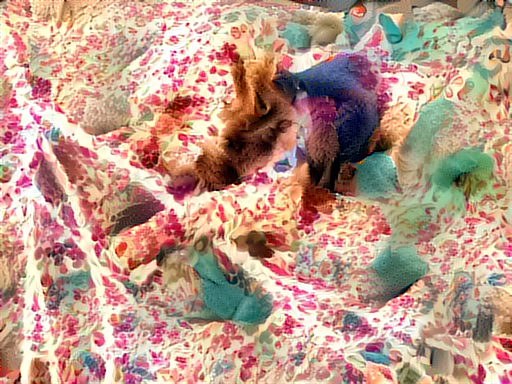

Total time: 39.1


In [14]:
content_path = 'IMG_2591.JPG'
content_path_a = '/content/Bacchus.jpg'
style_path = '/content/Gleizes_The_Bridges_of_Paris.jpg'
style_path_0 = '/content/Galaofspheres.jpg'
style_path_1 = '/content/Delaunay_Window_on_the_City.jpg'
style_path_2 = '/content/Christ_in_Limbo.jpg'
style_path_3 = '/content/Kandinsky_Composition_7.jpg'
style_path_4 = '/content/Babel_Bruegel.jpg'
style_path_5 = '/content/Pollock_bw.jpg'
style_path_6 = '/content/Pollock_Head.jpg'
style_path_7 = '/content/Tondals_Vision.jpg'
style_path_8 = '/content/The_Triumph_of_Death_Bruegel.jpg'
style_path_9 = '/content/Metzinger_Two_Nudes.jpg'

[c_w,s_w,v_w] = [1,1,1]
[c_p,s_p,v_p] = [1.5,0.5,1]
[lr,beta1,beta2,epochs]=[0.01,0.98,0.9999,15]
newim, losses = build_image(content_path_a,content_path,lr=lr,beta1=beta1,beta2=beta2,epochs=epochs,weights=[c_w,s_w,v_w],powers=[c_p,s_p,v_p])

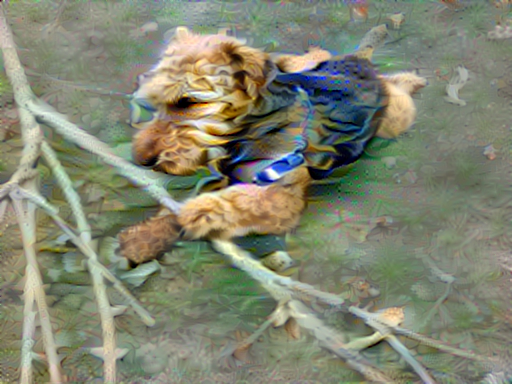

tf.Tensor(7.339343e-05, shape=(), dtype=float32)
Total time: 17.9


In [484]:
# this setting is for a softer change

[c_w,s_w,v_w] = [10,1,1]
[c_p,s_p,v_p] = [1,1,1]
[lr,beta1,beta2,epochs]=[0.01,0.98,0.9999,10]
newim, losses = build_image(content_path_a,style_path,lr=lr,beta1=beta1,beta2=beta2,epochs=epochs,weights=[c_w,s_w,v_w],powers=[c_p,s_p,v_p])

In [485]:
filename = 'Bacchus_Spheres2.png'
plt.imsave('Images/'+filename,np.array(newim[0]))

In [466]:
!tar -czf BacchusImages.tar.gz Images